# **INFO5731 In-class Exercise 4**

**This exercise will provide a valuable learning experience in working with text data and extracting features using various topic modeling algorithms. Key concepts such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA), lda2vec, and BERTopic.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## Question 1 (10 Points)

**Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [80]:
!pip install pyLDAvis

In [81]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import nltk
nltk.download('stopwords')


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# New text data
new_text = [
    "Thunderous wallop! Start the tuk tuk indeed. A stunning crashing blow to achieve it.",
    "It was a full delivery and Dhoni has sent the white ball flying over long-on.",
    "The dressing room erupts with joy. Dhoni had a poor batting record in World cups. "
    "And what does he do? He promotes himself and has played a fine knock to pull this off. "
    "Yuvraj envelops him with a hug. What a knock from Gautam Gambhir and Dhoni. "
    "Spare a thought for Mahela Jayawardene who unfurled a sublime knock to set up this target. "
    "It's India's night though. It's Dhoni's night. India are the world champions."
]

# Convert the new text data to a list
data = new_text

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data)

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words)

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized)

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus)

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['Thunderous wallop! Start the tuk tuk indeed. A stunning crashing blow to '
 'achieve it.',
 'It was a full delivery and Dhoni has sent the white ball flying over '
 'long-on.',
 'The dressing room erupts with joy. Dhoni had a poor batting record in World '
 'cups. And what does he do? He promotes himself and has played a fine knock '
 'to pull this off. Yuvraj envelops him with a hug. What a knock from Gautam '
 'Gambhir and Dhoni. Spare a thought for Mahela Jayawardene who unfurled a '
 'sublime knock to set up this target. Its Indias night though. Its Dhonis '
 'night. India are the world champions.']
[['thunderous', 'wallop', 'start', 'the', 'tuk', 'tuk', 'indeed', 'stunning', 'crashing', 'blow', 'to', 'achieve', 'it'], ['it', 'was', 'full', 'delivery', 'and', 'dhoni', 'has', 'sent', 'the', 'white', 'ball', 'flying', 'over', 'long', 'on'], ['the', 'dressing', 'room', 'erupts', 'with', 'joy', 'dhoni', 'had', 'poor', 'batting', 'record', 'in', 'world', 'cups', 'and', 'what', 'does',

## Question 2 (10 Points)

**Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

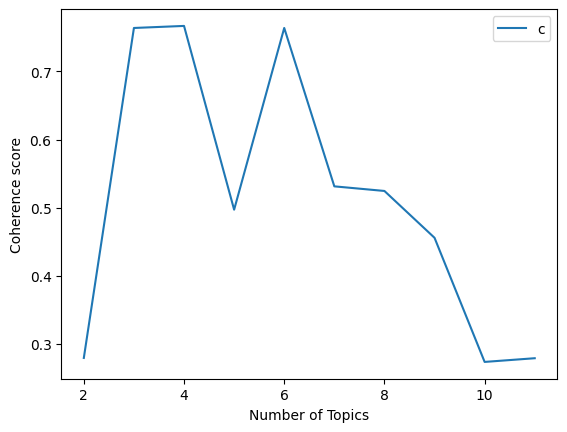

[(0, '0.404*"dhoni" + 0.396*"knock" + 0.264*"india" + 0.264*"night" + 0.264*"world" + 0.132*"unfurl" + 0.132*"dress" + 0.132*"spare" + 0.132*"jayawarden" + 0.132*"joy"'), (1, '0.577*"tuk" + 0.289*"crash" + 0.289*"wallop" + 0.289*"inde" + 0.289*"start" + 0.289*"stun" + 0.289*"thunder" + 0.289*"blow" + 0.289*"achiev" + 0.000*"world"'), (2, '-0.357*"full" + -0.357*"deliveri" + -0.357*"ball" + -0.357*"white" + -0.357*"long" + -0.357*"fli" + -0.357*"sent" + -0.292*"dhoni" + 0.065*"knock" + 0.044*"world"')]


In [82]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

def preprocess_data(doc_set):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))
    p_stemmer = PorterStemmer()
    texts = []
    for i in doc_set:
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in en_stop]
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        texts.append(stemmed_tokens)
    return texts

def create_gensim_lsa_model(doc_clean, number_of_topics, words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean, start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start, step)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

# Commentary data
commentary = [
    "Thunderous wallop! Start the tuk tuk indeed. A stunning crashing blow to achieve it.",
    "It was a full delivery and Dhoni has sent the white ball flying over long-on.",
    "The dressing room erupts with joy. Dhoni had a poor batting record in World cups. "
    "And what does he do? He promotes himself and has played a fine knock to pull this off. "
    "Yuvraj envelops him with a hug. What a knock from Gautam Gambhir and Dhoni. "
    "Spare a thought for Mahela Jayawardene who unfurled a sublime knock to set up this target. "
    "It's India's night though. It's Dhoni's night. India are the world champions."
]

# Preprocess the commentary data
clean_commentary = preprocess_data(commentary)

# Plot the coherence graph
start, stop, step = 2, 12, 1
plot_graph(clean_commentary, start, stop, step)

# LSA Model
number_of_topics = 7
words = 10
model = create_gensim_lsa_model(clean_commentary, number_of_topics, words)


## Question 3 (10 points):
**Generate K topics by using lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

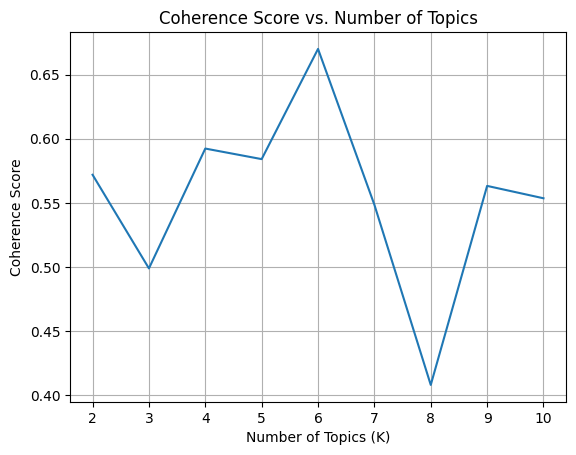

Optimal Number of Topics (K): 6
Topic 0: 0.013*"a" + 0.013*"and" + 0.013*"knock" + 0.013*"with" + 0.013*"world" + 0.013*"he" + 0.013*"the" + 0.013*"to" + 0.013*"what" + 0.013*"this"
Topic 1: 0.042*"a" + 0.042*"and" + 0.042*"the" + 0.042*"has" + 0.042*"dhoni" + 0.041*"long-on." + 0.041*"flying" + 0.041*"was" + 0.041*"ball" + 0.041*"it"
Topic 2: 0.013*"a" + 0.013*"the" + 0.013*"to" + 0.013*"has" + 0.013*"dhoni" + 0.013*"and" + 0.013*"stunning" + 0.013*"white" + 0.013*"full" + 0.013*"indeed."
Topic 3: 0.080*"tuk" + 0.043*"the" + 0.043*"to" + 0.043*"wallop!" + 0.043*"crashing" + 0.043*"thunderous" + 0.043*"it." + 0.043*"start" + 0.043*"achieve" + 0.043*"blow"
Topic 4: 0.013*"a" + 0.013*"and" + 0.013*"the" + 0.013*"with" + 0.013*"knock" + 0.013*"this" + 0.013*"world" + 0.013*"he" + 0.013*"it's" + 0.013*"to"
Topic 5: 0.070*"a" + 0.036*"knock" + 0.036*"and" + 0.025*"he" + 0.025*"it's" + 0.025*"with" + 0.025*"to" + 0.025*"this" + 0.025*"what" + 0.025*"the"


In [83]:
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

try:
    import seaborn
except ImportError:
    pass

# Sample text data
commentary = [
    "Thunderous wallop! Start the tuk tuk indeed. A stunning crashing blow to achieve it.",
    "It was a full delivery and Dhoni has sent the white ball flying over long-on.",
    "The dressing room erupts with joy. Dhoni had a poor batting record in World cups. "
    "And what does he do? He promotes himself and has played a fine knock to pull this off. "
    "Yuvraj envelops him with a hug. What a knock from Gautam Gambhir and Dhoni. "
    "Spare a thought for Mahela Jayawardene who unfurled a sublime knock to set up this target. "
    "It's India's night though. It's Dhoni's night. India are the world champions."
]

# Tokenize and preprocess text data
tokenized_commentary = [commentary.lower().split() for commentary in commentary]

# Create dictionary and corpus
dictionary = corpora.Dictionary(tokenized_commentary)
corpus = [dictionary.doc2bow(commentary) for commentary in tokenized_commentary]

# Function to compute coherence score for a given LDA model
def compute_coherence_score(corpus, dictionary, k):
    lda_model = models.LdaModel(corpus, id2word=dictionary, num_topics=k, passes=10)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_commentary, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

# Determine the optimal number of topics based on coherence score
min_topics = 2
max_topics = 10
step = 1
coherence_scores = []
for k in range(min_topics, max_topics + 1, step):
    coherence_score = compute_coherence_score(corpus, dictionary, k)
    coherence_scores.append(coherence_score)

# Plot coherence scores
plt.plot(range(min_topics, max_topics + 1, step), coherence_scores)
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid(True)
plt.show()

# Select the optimal number of topics (K)
optimal_k = coherence_scores.index(max(coherence_scores)) + min_topics
print("Optimal Number of Topics (K):", optimal_k)

# Train the final LDA model with the optimal number of topics
final_lda_model = models.LdaModel(corpus, id2word=dictionary, num_topics=optimal_k, passes=10)

# Extract and summarize topics from the final model
final_topics = final_lda_model.print_topics(num_words=10)
for topic in final_topics:
    print("Topic {}: {}".format(topic[0], topic[1]))

## Question 4 (10 points):
**Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [22]:
%%capture
!pip install bertopic

In [23]:
from sklearn.datasets import fetch_20newsgroups
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

In [25]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)



Batches:   0%|          | 0/589 [00:00<?, ?it/s]

In [38]:
topic_model.get_topic(0)  # Select the most frequent topic

[('game', 0.010260355789178296),
 ('team', 0.008945440584214275),
 ('games', 0.007129920037587685),
 ('he', 0.006915715444110532),
 ('players', 0.006260094302514763),
 ('season', 0.006203777513069043),
 ('hockey', 0.006081771586470815),
 ('play', 0.005725021956423557),
 ('25', 0.005594516236697655),
 ('year', 0.0055516901651782745)]

In [39]:
topic_model.topics_[:10]

[0, -1, -1, 54, 81, -1, 40, 0, 0, -1]

In [40]:
topic_model.visualize_topics()

In [41]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [42]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [43]:
topic_model.visualize_barchart(top_n_topics=5)


In [44]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [45]:
topic_model.visualize_term_rank()

In [46]:
topic_model.update_topics(docs, n_gram_range=(1, 2))

In [47]:
topic_model.get_topic(0)

[('game', 0.006524298962449406),
 ('team', 0.005580467251123394),
 ('he', 0.005205564196014816),
 ('games', 0.0044030847644624645),
 ('the', 0.0038974455959436645),
 ('players', 0.0037711209942787225),
 ('season', 0.0037356503335914844),
 ('was', 0.0037026530364958976),
 ('hockey', 0.0036519868997916803),
 ('year', 0.0035909992406330305)]

In [48]:
topic_model.reduce_topics(docs, nr_topics=60)

In [49]:
# Access the newly updated topics with:
print(topic_model.topics_)

similar_topics, similarity = topic_model.find_topics("vehicle", top_n=5); similar_topics

topic_model.get_topic(71)

[0, -1, -1, 18, 33, -1, 14, 0, 0, -1, -1, -1, -1, 17, 7, 12, -1, 0, 2, 3, -1, 1, -1, 3, 0, -1, 0, -1, -1, 11, -1, 0, 1, 0, 5, 9, -1, 19, 3, 2, -1, 1, 15, 5, 0, -1, -1, 1, 2, -1, -1, -1, -1, 2, 19, 29, -1, -1, -1, 2, 0, -1, 1, -1, -1, 44, 0, -1, -1, -1, 8, -1, 1, 1, -1, -1, 0, 1, -1, 0, 20, 3, 1, 15, 8, -1, -1, 10, -1, 0, 0, 6, 0, 1, 12, 8, 1, -1, 0, 5, 48, -1, -1, 4, 6, 0, -1, -1, -1, 1, 9, 3, 7, 1, 12, 0, -1, 44, 0, -1, -1, 28, -1, -1, 2, 22, -1, 6, -1, -1, 50, 0, -1, 0, 18, 6, 1, 2, -1, 2, -1, 9, 0, 1, -1, 2, 9, 1, 0, -1, 3, 3, 18, 1, 35, -1, -1, 4, 7, 1, -1, 6, 13, -1, -1, -1, 0, 7, 1, 5, 8, -1, 0, -1, -1, -1, 0, -1, -1, 0, 3, 0, 0, -1, -1, 6, -1, 0, 12, -1, 1, 34, 6, 0, 0, 0, 12, -1, -1, 1, -1, -1, -1, -1, -1, -1, 5, 11, 16, 0, -1, 1, -1, 1, 3, 0, -1, 11, 7, 6, 0, 0, -1, 3, 2, -1, 2, -1, -1, 0, -1, -1, -1, 5, 0, -1, 0, 0, 0, 1, 21, 21, 5, -1, -1, 1, 30, -1, -1, 4, 1, -1, 5, -1, 7, -1, 13, -1, -1, -1, 21, -1, -1, -1, 1, -1, 1, -1, -1, 1, 22, -1, 30, 1, 5, -1, 12, -1, 22, 0, 5, 0, -1

False

In [50]:
# Save model
topic_model.save("my_model")


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [51]:
# Load model
my_model = BERTopic.load("my_model")

topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")

In [87]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens", device="cpu")
topic_model = BERTopic(embedding_model=sentence_model, verbose=True)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Extra Question (5 Points)

**Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.**

**This question will compensate for any points deducted in this exercise. Maximum marks for the exercise is 40 points.**

When comparing the outcomes of LDA, LSA, and LDA2vec, it's critical to consider both the computing efficiency and coherence of each method. Let's examine coherence first. Because LDA and Lda2vec can capture semantic links in word-to-word phrases, they both generate coherence themes. While LDA counts the co-occurrence of words in topics to determine coherence, Lda2vec performs the same thing in addition to adding word embedding, producing topics that are more consistent and complex. In contrast, LSA captures latent semantic links but does not evaluate coherence directly. LSA generates subjects that frequently exhibit coherence for this reason. Lastly, by considering the intricate semantic linkages represented in the BERT embedding, BERTopic produces high-coherence topics.Another important factor is interpretability. LDA and Lda2vec generate topics as lists of words that are relatively easy to interpret, while LDA topics are distributions of words that often co-occur within the same corpus. Lda2vec’s ability to capture more complex semantic relationships may require more in-depth analysis for interpretation, while LSA topics derived from mathematical transformations are likely to be less interpretable. BERTopic, on the other hand, may generate less interpretable topics because understanding the particular semantic relationships encoded in the BERT embedding requires expertise in Natural Language Processing (NLP). LDA stands out in terms of its computational efficiency and scalability, as it can process millions of documents efficiently. LSA can struggle with scalability, as the SVD process has a high computational intensity. On the other hand, lda2vec is slower during training because it learns word embeddings along with topic modeling, but becomes more comparable with LDA once it is trained. BERTopic on the other hand may be slower, particularly for large datasets, as it has a high computational demands to generate each word and document BERT embedding.The answer to choosing the "best" algorithm varies depending on the kind of work you are trying to accomplish. If you wish to concentrate on interpretability or coherence, LDA or Lda2vec would be a better option. Although LDA is more simply interpretable, Lda2vec is better at capturing intricate semantic links. Given that BERTopic depends on advanced BERT embedding, it might be a superior choice for tasks requiring more sophisticated semantic understanding. LDA or LDA2vec may be a better option depending on the computing efficiency of your task, particularly if you're working with large datasets.In summary, the optimal algorithm depends on the particular objectives, the properties of the data, and the computational resources that are available. Every algorithm has benefits and drawbacks. Selecting the optimal algorithm for a given NLP task requires an understanding of the trade-offs between each algorithm's benefits and drawbacks. You must test and refine the algorithm in accordance with the particular objectives of the work.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.

Consider the following points in your response:

**Learning Experience:** Describe your overall learning experience in working with text data and extracting features using various topic modeling algorithms. Did you understand these algorithms and did the implementations helped in grasping the nuances of feature extraction from text data.

**Challenges Encountered:** Were there specific difficulties in completing this exercise?

Relevance to Your Field of Study: How does this exercise relate to the field of NLP?

**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
#Please write you answer here: I was able to gain practical experience with topic modeling and text data analysis through the exercises, which improved my understanding of methods like LDA and LSA as well as lda2vec & BERTopic. I was able to learn the subtleties of feature extraction from text data by using these techniques, which also helped me grasp when and how to apply them in natural language processing.

#Because of their intricacy, advanced approaches like ida2vec and bERTopic were difficult for me to understand. It required more work to comprehend them and adjust the parameters. Interpreting algorithm findings, in particular coherence & interpretability measures, was another challenge for me.





'''